In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearningLabs/Lab4/Publish/data/'
myDrive = '/content/drive/My Drive/DeepLearningLabs/Lab4/Publish/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
binary.npy   names	  Sales_store.csv
decimal.npy  RNN-SIN.pkl  Sales_store_mean.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


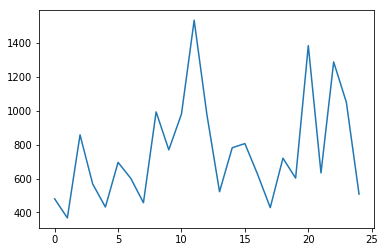

In [0]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random
import matplotlib.pyplot as plt
import pandas as pd
from operator import truediv

device = "cuda" if torch.cuda.is_available else "device"

dataDir = myDrive+'Sales_store.csv'
dataDir = myDrive+'Sales_store_mean.csv'
data = pd.read_csv(dataDir).as_matrix()
data = np.asarray(data[:,1],dtype=np.float32)

totalData = len(data) 

def sample(data,begin,end):
    if end < len(data-1) and begin >= 0 : 
        return data[begin:end]

begin = 0; end = 25
_inputs =  sample(data,begin,end)
plt.plot(_inputs)


## Overal task: 
Using this new data, create your own network to perform the prediction following example on 3-1_3-TimeSeriesRNNAnswer.ipynb

## Data preprocessing

In [0]:
data = pd.read_csv(dataDir).as_matrix()
data = np.asarray(data[:,1],dtype=np.float32)
data = torch.from_numpy(data).float().unsqueeze(0).unsqueeze(0).to(device)
#data = data/data.max()
print(data.size())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


torch.Size([1, 1, 48])


## RNN model

In [0]:
class LSTM_FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_FCN, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
        
        # One time step
        out, hn = self.lstm(x, (h0, c0))
        out = self.fc(out)
        out = self.ReLU(out)
        return out

In [0]:
class RNN_FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_FCN, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
        
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        out = self.ReLU(out)
        return out

In [0]:
num_epoch = 100

# Create RNN
input_dim = 32    # input dimension
hidden_dim = 256   # hidden layer dimension
layer_dim = 1    # number of hidden layers
output_dim = 1   # output dimension

model = LSTM_FCN(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Mean Squared Error
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.9, weight_decay=0.9)

In [0]:
loss_list = []
samples_per_step = input_dim

for epoch in range(num_epoch):
  for i in range(0, data.shape[-1]):

    # Clear gradients
    optimizer.zero_grad()
    
    if i+samples_per_step+1 >= data.shape[-1]:
      continue
      
    x = data[:, :, i:i+samples_per_step]
    y = data[:, :, i+samples_per_step+1]
    
    # Forward propagation
    outputs = model(x)
    #print("INPUT", x)
    #print(y)
    #print(outputs)
    
    # Calculate softmax and MSE loss
    loss = error(outputs, y)
    
    # Calculating gradients
    loss.backward()
    
    loss_list.append(loss.item())

    # Update parameters
    optimizer.step()
    
    print(f'loss : {loss.item()}')
    


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss : 17922.841796875
loss : 39346.92578125
loss : 171.99977111816406
loss : 2963.15576171875
loss : 3826.004638671875
loss : 32.74320602416992
loss : 535.6919555664062
loss : 10905.330078125
loss : 11.731795310974121
loss : 289.87432861328125
loss : 12.813026428222656
loss : 9.924192428588867
loss : 28081.95703125
loss : 16426.08984375
loss : 8172.4736328125
loss : 31290.400390625
loss : 34956.08203125
loss : 219.6163330078125
loss : 3028.955810546875
loss : 4271.35302734375
loss : 13.419540405273438
loss : 371.64892578125
loss : 10882.5107421875
loss : 1.9693078994750977
loss : 316.84173583984375
loss : 11.499235153198242
loss : 14.0643310546875
loss : 28118.484375
loss : 16451.287109375
loss : 8171.83349609375
loss : 31255.515625
loss : 34842.015625
loss : 198.84718322753906
loss : 2983.4873046875
loss : 4682.6806640625
loss : 4.481707572937012
loss : 255.82327270507812
loss : 10841.341796875
loss : 27.068063735961914
loss : 343.9503479003906
loss : 9.526400566101074
loss : 19.0222

## Test

In [0]:
torch.save(model.state_dict(), myDrive+"RNN-SIN.pkl")

tensor([[624.8725]], device='cuda:0')
tensor([[[768.0089]]], device='cuda:0', grad_fn=<ReluBackward0>)
32
tensor([[1271.3451]], device='cuda:0')
tensor([[[1193.5900]]], device='cuda:0', grad_fn=<ReluBackward0>)
33
tensor([[1410.7198]], device='cuda:0')
tensor([[[1376.5574]]], device='cuda:0', grad_fn=<ReluBackward0>)
34
tensor([[397.6021]], device='cuda:0')
tensor([[[404.7086]]], device='cuda:0', grad_fn=<ReluBackward0>)
35
tensor([[528.1798]], device='cuda:0')
tensor([[[448.4345]]], device='cuda:0', grad_fn=<ReluBackward0>)
36
tensor([[544.6722]], device='cuda:0')
tensor([[[507.0295]]], device='cuda:0', grad_fn=<ReluBackward0>)
37
tensor([[453.2979]], device='cuda:0')
tensor([[[395.9286]]], device='cuda:0', grad_fn=<ReluBackward0>)
38
tensor([[678.3023]], device='cuda:0')
tensor([[[698.8809]]], device='cuda:0', grad_fn=<ReluBackward0>)
39
tensor([[826.4603]], device='cuda:0')
tensor([[[827.9409]]], device='cuda:0', grad_fn=<ReluBackward0>)
40
tensor([[562.5248]], device='cuda:0')
tens

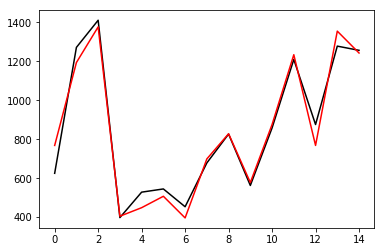

In [0]:
model.eval()
initial = 2

x = []
y = []
for i in range(samples_per_step):
  if i+samples_per_step+1 >= data.shape[-1]:
      continue
  x.append(data[:,:,i+samples_per_step+1])
  y.append(model(data[:,:,i:i+samples_per_step]).item())
  
  print(data[:,:,i+samples_per_step+1])
  print(model(data[:,:,i:i+samples_per_step]))
  print(i+samples_per_step)
  
plt.plot(x, color='k')
plt.plot(y, color='r')
plt.show()